# Data 620 Project 2
Matthew Tillmawitz

For this project we have been tasked with:
1. Identifying a large 2-node network dataset that consists of ties between and not within two (or more) distinct groups.
2. Reduce the size of the network using a method such as the island method.
3. Analyze the groups and draw conclusions.

We have chosen to use an arXiv dataset compiled by Cornell University [found on Kaggle](https://www.kaggle.com/datasets/Cornell-University/arxiv?resource=download) tracking metadata on scholarly papers published across a number of STEM fields. From this dataset we extracted the papers and authors and constructed a bimodal graph with edges representing authorship of a paper. As many papers have multiple authors, we are able to analyze the graph to get a better understanding of the collaboration patterns in various STEM fields and the level of crossover between these fields.

In [46]:
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
from networkx.algorithms import bipartite, community
import matplotlib.patches as mpatches
import pandas as pd
import numpy as np
from collections import Counter

In [47]:
df = pd.read_csv('/Users/matttillman/School/data_620/data/arxiv_cs_ai_bipartite.csv')
B = nx.Graph()

authors = df['author'].unique()
papers = df['paper'].unique()

B.add_nodes_from(authors, bipartite=0)
B.add_nodes_from(papers, bipartite=1)
# Can't handle df directly, need to zip columns together to get tuples
B.add_edges_from(zip(df['author'], df['paper']))

/var/folders/m9/g63t6db10t1byfz1txs0l4t00000gn/T/ipykernel_49730/1802281986.py:1: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('/Users/matttillman/School/data_620/data/arxiv_cs_ai_bipartite.csv')


The graph is quite extensive, with several hundred thousand nodes and edges. There are more authors than papers which is to be expected given the collaborative nature of academic research. There are over 12,000 components of this network, however the largest component has over 75% of the total nodes. As such we will focus our analysis on the largest connected component and disregard the numerous small components.

In [48]:
print(f"Total nodes: {B.number_of_nodes()}")
print(f"Total edges: {B.number_of_edges()}")
print(f"Authors: {len(authors)}")
print(f"Papers: {len(papers)}")

Total nodes: 407522
Total edges: 698657
Authors: 262828
Papers: 144694


In [49]:
components = list(nx.connected_components(B))
print(f"Number of components: {len(components)}")

component_sizes = sorted([len(c) for c in components], reverse=True)
top_ten_components = component_sizes[:10]
print(f"Top 10 largest components: {top_ten_components}")


Number of components: 12801
Top 10 largest components: [345173, 787, 96, 79, 65, 55, 51, 50, 49, 48]


## Largest Component

As noted, the largest component consists of the vast majority of nodes and virtually all of the edges. The density of the network is extremely low and reflects both the difficulty of coordinating large numbers of authors on a single paper as well as the work that goes into publishing a paper with few authors having large bodies of work.

In [50]:
largest_component = max(nx.connected_components(B), key=len)
B_main = B.subgraph(largest_component).copy()

author_nodes = [n for n, d in B_main.nodes(data=True) if d['bipartite'] == 0]
paper_nodes = [n for n, d in B_main.nodes(data=True) if d['bipartite'] == 1]

print(f"Nodes: {B_main.number_of_nodes()}")
print(f"Edges: {B_main.number_of_edges()}")
# Doesn't matter which node set you use
print(f"Density: {bipartite.density(B_main, author_nodes)}")

Nodes: 345173
Edges: 645038
Density: 2.3386564655814418e-05


The degree distributions of both author and paper nodes further highlight the relatively small number of papers authors tend to produce. Both plots have logarithmic scales on the y-axis, as the vast majority of authors produce a single paper and virtually all papers have only a handful of authors. The relatively small output of authors can reflect a number of factors, including but not limited to PhD dissertations and publications by those who enter industry instead of academia as well as publications from researchers at for profit companies that seek to keep most research breakthroughs proprietary. In spite of this there is a not insignificant number of researchers who produce tens of papers who are of particular interest. These individuals are likely driving much of the progress in their fields, and the networks they form represent the cores of the research and development in their respective fields.

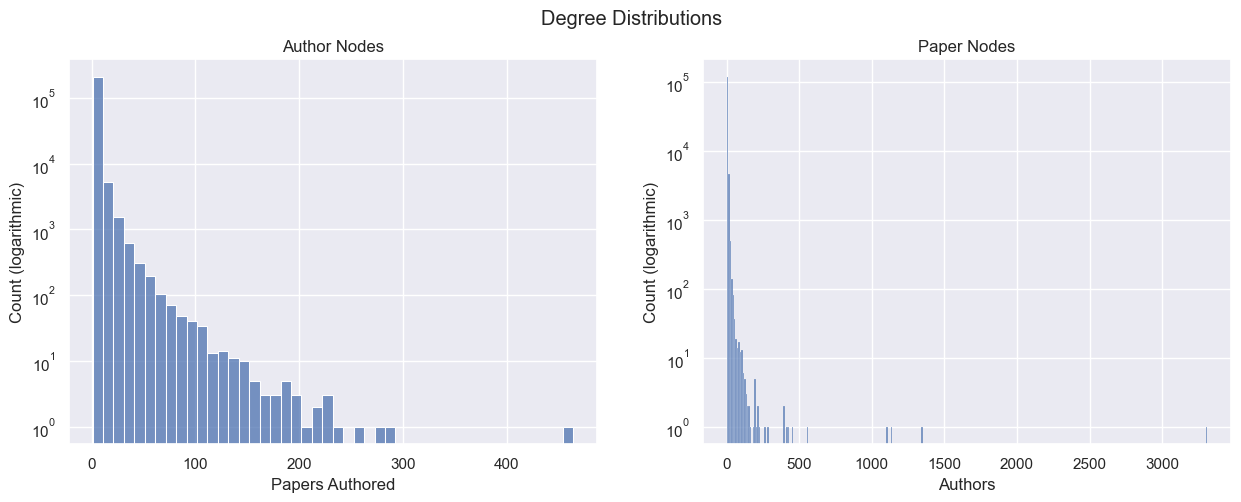

In [51]:
# Double check if this needs to be in dict form
author_degrees = dict(B_main.degree(author_nodes))
paper_degrees = dict(B_main.degree(paper_nodes))

sns.set_theme()

fig, axes = plt.subplots(1, 2, figsize=(15, 5))
fig.suptitle("Degree Distributions")

sns.histplot(data=author_degrees, binwidth=10, ax=axes[0])
axes[0].set_yscale('log')
axes[0].set_title("Author Nodes")
axes[0].set_xlabel("Papers Authored")
axes[0].set_ylabel("Count (logarithmic)")

sns.histplot(data=paper_degrees, binwidth=10, ax=axes[1])
axes[1].set_yscale('log')
axes[1].set_title("Paper Nodes")
axes[1].set_xlabel("Authors")
axes[1].set_ylabel("Count (logarithmic)")

plt.show()

In [52]:
author_proj_weighted = bipartite.weighted_projected_graph(B_main, author_nodes)
paper_proj_weighted = bipartite.weighted_projected_graph(B_main, paper_nodes)

## Choosing Projection Thresholds

Projecting the bimodal graph into both author and paper projections allows us to better understand the networks that are formed. Given the larger number of nodes and millions of edges this results in, we need to develop criteria to decrease the size of the graphs in order to be able to perform meaningful analysis. We will be using the island method to eliminate low weight edges and the resulting isolated nodes to produce a dataset from which we can draw conclusions.

In [53]:
print(f"Author projection: {author_proj_weighted.number_of_nodes()} nodes, {author_proj_weighted.number_of_edges()} edges")
print(f"Paper projection: {paper_proj_weighted.number_of_nodes()} nodes, {paper_proj_weighted.number_of_edges()} edges")

Author projection: 219539 nodes, 10083777 edges
Paper projection: 125634 nodes, 4116101 edges


In order to determine the appropriate threshold for both projections, we will evaluate multiple cutoffs. From the summary statistics and percentiles it is clear that in the overwhelming majority of cases authors produce a single paper and papers have at most one author in common. These relationships indicate minimal levels of collaboration and are of little interest to us when attempting to identify core research groups and fields. However, eliminating edges with a weight of 2 or less results in so much data being removed as to make any conclusions we draw so niche that they lose any relevance. Therefore, for both projections we will leave the cutoff weight at 2 and elimate the edges with a value of 1 and the resulting isolated nodes.

In [54]:
def analyze_weight_distribution(G, graph_name="Graph"):
    """Analyze the distribution of edge weights"""
    weights = [d['weight'] for u, v, d in G.edges(data=True)]
    
    print(f"\n{graph_name} - Edge weight distribution:")
    print(f"  Total edges: {len(weights)}")
    print(f"  Min weight: {min(weights)}")
    print(f"  Max weight: {max(weights)}")
    print(f"  Mean weight: {np.mean(weights):.2f}")
    print(f"  Median weight: {np.median(weights):.2f}")
    print(f"  Std dev: {np.std(weights):.2f}")
    
    # Show percentiles
    percentiles = [25, 50, 75, 90, 95, 99]
    print(f"\n  Percentiles:")
    for p in percentiles:
        val = np.percentile(weights, p)
        print(f"    {p}th: {val:.2f}")
    
    # Count edges by weight
    print(f"\n  Edge count by weight threshold:")
    for threshold in [1, 2, 3, 5, 10, 20]:
        count = sum(1 for w in weights if w >= threshold)
        pct = 100 * count / len(weights)
        print(f"    Weight >= {threshold}: {count} edges ({pct:.1f}%)")
    
    return weights

# Analyze both projections
author_weights = analyze_weight_distribution(author_proj_weighted, "Author Projection")
paper_weights = analyze_weight_distribution(paper_proj_weighted, "Paper Projection")



Author Projection - Edge weight distribution:
  Total edges: 10083777
  Min weight: 1
  Max weight: 106
  Mean weight: 1.08
  Median weight: 1.00
  Std dev: 0.47

  Percentiles:
    25th: 1.00
    50th: 1.00
    75th: 1.00
    90th: 1.00
    95th: 2.00
    99th: 3.00

  Edge count by weight threshold:
    Weight >= 1: 10083777 edges (100.0%)
    Weight >= 2: 565607 edges (5.6%)
    Weight >= 3: 109607 edges (1.1%)
    Weight >= 5: 25820 edges (0.3%)
    Weight >= 10: 3749 edges (0.0%)
    Weight >= 20: 442 edges (0.0%)

Paper Projection - Edge weight distribution:
  Total edges: 4116101
  Min weight: 1
  Max weight: 722
  Mean weight: 1.17
  Median weight: 1.00
  Std dev: 0.74

  Percentiles:
    25th: 1.00
    50th: 1.00
    75th: 1.00
    90th: 2.00
    95th: 2.00
    99th: 4.00

  Edge count by weight threshold:
    Weight >= 1: 4116101 edges (100.0%)
    Weight >= 2: 459105 edges (11.2%)
    Weight >= 3: 142673 edges (3.5%)
    Weight >= 5: 22884 edges (0.6%)
    Weight >= 10: 113

Applying our cutoff criteria again produces unconnected components. Upon further analysis we can see that the components follow the same pattern as the main bipartite graph with the largest component consisting of the vast majority of the edges and nodes, meaning we can consider the largest component on its own.

In [55]:
def filter_by_weight(G, min_weight=2,):
    # Create a copy to modify
    G_filtered = G.copy()
    
    # Remove low-weight edges and resulting isolated nodes
    edges_to_remove = [(u, v) for u, v, d in G_filtered.edges(data=True) 
                       if d['weight'] < min_weight]
    G_filtered.remove_edges_from(edges_to_remove)
    isolated_nodes = list(nx.isolates(G_filtered))
    G_filtered.remove_nodes_from(isolated_nodes)
    
    n_components = nx.number_connected_components(G_filtered)
    
    if n_components > 1:
        components = list(nx.connected_components(G_filtered))
        component_sizes = sorted([len(c) for c in components], reverse=True)
        
        # Get largest component
        largest_component = max(components, key=len)
        G_main = G_filtered.subgraph(largest_component).copy()
        
        return G_main, n_components
    else:
        return G_filtered, 1

def explore_weight_thresholds(G, thresholds=[2, 3, 5, 10]):
    results = []
    
    for threshold in thresholds:
        G_filtered, n_components = filter_by_weight(G, min_weight=threshold)
        results.append({
            'threshold': threshold,
            'components': n_components,
            'largest comp nodes': G_filtered.number_of_nodes(),
            'largest comp edges': G_filtered.number_of_edges(),
            'density': nx.density(G_filtered),
            'avg_clustering': nx.average_clustering(G_filtered) if G_filtered.number_of_edges() > 0 else 0
        })
    
    df_results = pd.DataFrame(results)
    
    return df_results

author_threshold_results = explore_weight_thresholds(
    author_proj_weighted, 
    thresholds=[2, 3, 5]
)
author_threshold_results

,threshold,components,largest comp nodes,largest comp edges,density,avg_clustering
0,2,3783,61581,547819,0.000289,0.629097
1,3,3250,28546,97846,0.000240,0.529720
2,5,2081,8898,19433,0.000491,0.433714


In [56]:
paper_threshold_results = explore_weight_thresholds(
    paper_proj_weighted,
    thresholds=[2, 3, 5]
)
paper_threshold_results

,threshold,components,largest comp nodes,largest comp edges,density,avg_clustering
0,2,9091,63518,406294,0.000201,0.656233
1,3,11479,21578,87714,0.000377,0.599990
2,5,5114,589,1353,0.007813,0.518566


In [57]:
def filter_by_weight(G, min_weight=2):
    G_filtered = G.copy()
    
    edges_to_remove = [(u, v) for u, v, d in G_filtered.edges(data=True) 
                       if d['weight'] < min_weight]
    G_filtered.remove_edges_from(edges_to_remove)
    
    print(f"Removed {len(edges_to_remove)} edges with weight < {min_weight}")
    print(f"Remaining edges: {G_filtered.number_of_edges()}")
    
    isolated_nodes = list(nx.isolates(G_filtered))
    G_filtered.remove_nodes_from(isolated_nodes)
    
    print(f"Removed {len(isolated_nodes)} isolated nodes")
    print(f"Remaining nodes: {G_filtered.number_of_nodes()} ({100*G_filtered.number_of_nodes()/G.number_of_nodes():.1f}%)")
    
    n_components = nx.number_connected_components(G_filtered)
    print(f"\nConnected components: {n_components}")
    
    if n_components > 1:
        components = list(nx.connected_components(G_filtered))
        component_sizes = sorted([len(c) for c in components], reverse=True)
        print(f"Top 10 component sizes: {component_sizes[:10]}")
        
        largest_component = max(components, key=len)
        G_main = G_filtered.subgraph(largest_component).copy()
        
        print(f"\nLargest component:")
        print(f"  Nodes: {G_main.number_of_nodes()} ({100*G_main.number_of_nodes()/G_filtered.number_of_nodes():.1f}% of filtered)")
        print(f"  Edges: {G_main.number_of_edges()} ({100*G_main.number_of_edges()/G_filtered.number_of_edges():.1f}% of filtered)")
        
        return G_main
    else:
        print("Graph remains connected!")
        return G_filtered

# This is just the largest component
author_proj_final = filter_by_weight(author_proj_weighted, 2)

Removed 9518170 edges with weight < 2
Remaining edges: 565607
Removed 144319 isolated nodes
Remaining nodes: 75220 (34.3%)

Connected components: 3783
Top 10 component sizes: [61581, 38, 37, 31, 25, 25, 24, 24, 23, 23]

Largest component:
  Nodes: 61581 (81.9% of filtered)
  Edges: 547819 (96.9% of filtered)


In [58]:
paper_proj_final = filter_by_weight(paper_proj_weighted, 2)

Removed 3656996 edges with weight < 2
Remaining edges: 459105
Removed 29623 isolated nodes
Remaining nodes: 96011 (76.4%)

Connected components: 9091
Top 10 component sizes: [63518, 88, 76, 71, 68, 54, 48, 45, 43, 41]

Largest component:
  Nodes: 63518 (66.2% of filtered)
  Edges: 406294 (88.5% of filtered)


Looking at the full extent of the impact of our filtering on the dataset, we can see that the paper projection retains the vast majoriity of nodes and adges, making the conclusions we draw more generalizable to the full dataset. The author projection, however, loses the vast majority of the total contributors. While this may be problematic for many research purposes, we have already indicated our analysis of authors is intended to identify the core networks driving innovation in different subfields. Given most authors only produce a single paper, they are unlikely to be influential in their field. We can therefore proceed with confidence in the relevance of the conclusions we draw from our analysis while keeping in mind these conclusions should not be applied to the total population of researchers.

In [59]:
print(f"\nAuthor collaboration network (weight >= 2):")
print(f"  Nodes: {author_proj_final.number_of_nodes()}")
print(f"  Edges: {author_proj_final.number_of_edges()}")
print(f"  Density: {nx.density(author_proj_final):.6f}")
print(f"  Average clustering: {nx.average_clustering(author_proj_final):.4f}")
print(f"  Transitivity: {nx.transitivity(author_proj_final):.4f}")

final_weights = [d['weight'] for u, v, d in author_proj_final.edges(data=True)]
print(f"\n  Edge weights in final network:")
print(f"    Mean: {np.mean(final_weights):.2f}")
print(f"    Median: {np.median(final_weights):.2f}")
print(f"    Max: {max(final_weights)}")


Author collaboration network (weight >= 2):
  Nodes: 61581
  Edges: 547819
  Density: 0.000289
  Average clustering: 0.6291
  Transitivity: 0.9262

  Edge weights in final network:
    Mean: 2.42
    Median: 2.00
    Max: 106


In [60]:
print(f"\nPaper co-citation network (weight >= 2):")
print(f"  Nodes: {paper_proj_final.number_of_nodes()}")
print(f"  Edges: {paper_proj_final.number_of_edges()}")
print(f"  Density: {nx.density(paper_proj_final):.6f}")


Paper co-citation network (weight >= 2):
  Nodes: 63518
  Edges: 406294
  Density: 0.000201


## Analysis of Projections

The transitivity of the author projection can tell us how tightly knit the research communitites are. The very high global clustering coefficient of 0.93 indicates the tightly knit nature of researach communities, with authors in these communities having collaborated with most of the members of their community. It is likely those with large numbers of papers authored work in tight-knit research teams in which their collaborators also collaborate. The much lower average clustering coefficient indicates that more peripheral members of these research circles are less clustered, and given the distribution in the number of papers authored we observed earlier we can conclude these less prolific authors likely bring the average down to a lower value than we might expect from highly clustered communitites. These researchers are likely students or post-docs that work with these core research teams.

In [61]:
transitivity = nx.transitivity(author_proj_final)
print(f"Author transitivity (global clustering): {transitivity:.4f}")
avg_clustering = nx.average_clustering(author_proj_final)
print(f"Author average clustering coefficient: {avg_clustering:.4f}")

Author transitivity (global clustering): 0.9262
Author average clustering coefficient: 0.6291


The clustering of the paper projection is much lower than that of the author projection, indicating there is some research coherence but it is not overwhelming. The moderate values of both metrics mean that while papers frequently share some co-authors it is equally common that new researchers are included.

In [62]:
transitivity = nx.transitivity(paper_proj_final)
print(f"Paper transitivity (global clustering): {transitivity:.4f}")
avg_clustering = nx.average_clustering(paper_proj_final)
print(f"Paper average clustering coefficient: {avg_clustering:.4f}")

Paper transitivity (global clustering): 0.5869
Paper average clustering coefficient: 0.6562


The combination of the metrics from the two projections tells us much about the nature of the STEM research landscape. There tend to be prolific, core teams of researchers who collaborate frequently with more peripheral members, likely early in their research careers, who have more flexible collaboration patterns. Collaboration in these research groups tends to be between subsets of the group rather than the whole team with even highly cohesive teams having diversity in their collaboration patterns. This is inline with what we might expect given the nature of academic programs at universities.

Centrality metrics on networks this large do not provide a huge amount of insight, as they tend to fall victim to noise. They can be useful in highlighting key researchers or those with unusual contribution patterns however, and an example of one such relationship is demonstrated below. We can see that there are only a few researchers who are in the top 10 of both degree and eigenvector centrality, indicating they are both prolific and central researchers in their fields. Different measures could find different researchers with unusual collaboration patterns, however this goes beyond the relevance of our analysis.

In [63]:
degree_cent = nx.degree_centrality(author_proj_final)
eigenvector_cent = nx.eigenvector_centrality(author_proj_final, max_iter=1000)

measures = {
    'Degree': degree_cent,
    'Eigenvector': eigenvector_cent
}

for measure_name, measure_dict in measures.items():
    print(f"\n{measure_name} Centrality:")
    top_nodes = sorted(measure_dict.items(), key=lambda x: x[1], reverse=True)[:10]
    for i, (node, score) in enumerate(top_nodes, 1):
        print(f"  {i}. {node}: {score:.6f}")


Degree Centrality:
  1. Li Hui: 0.016531
  2. Zhao Yao: 0.015638
  3. Chen Xi: 0.015378
  4. Yang Fan: 0.014420
  5. Millican Katie: 0.014160
  6. Vinyals Oriol: 0.013949
  7. Hassabis Demis: 0.013868
  8. Tang Yunhao: 0.013852
  9. Reid Machel: 0.013852
  10. Silver David: 0.013771

Eigenvector Centrality:
  1. Millican Katie: 0.037738
  2. Reid Machel: 0.037697
  3. Georgiev Petko: 0.037635
  4. Kazemi Mehran: 0.037631
  5. Mohamed Kareem: 0.037630
  6. Gonzalez Lucas: 0.037626
  7. Shafey Laurent El: 0.037616
  8. Feng Fangxiaoyu: 0.037614
  9. Lee Lisa: 0.037582
  10. Silver David: 0.037511


Looking at the communities in the author projection, we can see there is an extremely high level of modularity, once again indicating tight knit research communities with few bridges between them. The distribution of community sizes indicates that, while there are certainly larger and smaller groups, there are not dominating comminities in this research area. 

In [64]:
communities_louvain = community.louvain_communities(author_proj_final, seed=8675309)
        
# Create partition dictionary (node -> community_id) for compatibility
partition = {}
for comm_id, comm_nodes in enumerate(communities_louvain):
    for node in comm_nodes:
        partition[node] = comm_id

# Calculate modularity
modularity = community.modularity(author_proj_final, communities_louvain)

n_communities = len(communities_louvain)
community_sizes = [len(c) for c in communities_louvain]

print(f"  Number of communities: {n_communities}")
print(f"  Modularity: {modularity:.4f}")
print(f"  Largest community: {max(community_sizes)} nodes")
print(f"  Smallest community: {min(community_sizes)} nodes")
print(f"  Average community size: {np.mean(community_sizes):.1f}")
print(f"  Median community size: {np.median(community_sizes):.1f}")

# Show distribution of community sizes
print(f"\n  Top 10 largest communities:")
sorted_sizes = sorted(enumerate(community_sizes), key=lambda x: x[1], reverse=True)
for i, (comm_id, size) in enumerate(sorted_sizes[:10], 1):
    print(f"    {i}. Community {comm_id}: {size} nodes ({100*size/author_proj_final.number_of_nodes():.1f}%)")

  Number of communities: 95
  Modularity: 0.7130
  Largest community: 3642 nodes
  Smallest community: 2 nodes
  Average community size: 648.2
  Median community size: 293.0

  Top 10 largest communities:
    1. Community 7: 3642 nodes (5.9%)
    2. Community 0: 2974 nodes (4.8%)
    3. Community 75: 2826 nodes (4.6%)
    4. Community 31: 2549 nodes (4.1%)
    5. Community 11: 2545 nodes (4.1%)
    6. Community 3: 2479 nodes (4.0%)
    7. Community 6: 2393 nodes (3.9%)
    8. Community 15: 2090 nodes (3.4%)
    9. Community 8: 2066 nodes (3.4%)
    10. Community 29: 1839 nodes (3.0%)


## Bipartite Analysis

Finally, considering the bipartite graph as a whole we can draw some last conclusions. Author contribution is highly right skewed with over half of all contributors producing a single paper. This, as before, is indicative of a large transient population of researchers, largely students, and a prolific core of researchers. The fact that over 96% of papers had multiple authors is interesting in comparison, indicating collaboration is the norm with an average of 5-6 authors per paper. The relatively low bipartite clustering indicates many collaborations are temporary, although this value is likely deceptive given what we know about the transient nature of many of the researchers in this area. There are much more stable cores with high levels of collaboration that frequently include contributions from these peripheral or transient researchers. The redundancy values indicate a moderate amount of information is potentially lost in the projections, with slightly more than half of a given author's collaborators having also collaborated with each other. As we have seen from other metrics and our analysis, this is consistent with what we know about the highly team based nature of the research groups.

In [65]:
print(f"\nDegree distributions by node type:")
    
author_degrees = dict(B.degree(author_nodes))
paper_degrees = dict(B.degree(paper_nodes))

print(f"\nAuthor degrees:")
print(f"  Mean: {np.mean(list(author_degrees.values())):.2f}")
print(f"  Median: {np.median(list(author_degrees.values())):.2f}")
print(f"  Max: {max(author_degrees.values())}")

print(f"\nPaper degrees (number of authors per paper):")
print(f"  Mean: {np.mean(list(paper_degrees.values())):.2f}")
print(f"  Median: {np.median(list(paper_degrees.values())):.2f}")
print(f"  Max: {max(paper_degrees.values())}")

single_author_papers = sum(1 for d in paper_degrees.values() if d == 1)
print(f"\nCollaboration patterns:")
print(f"  Single-author papers: {single_author_papers} ({100*single_author_papers/len(paper_degrees):.1f}%)")
print(f"  Multi-author papers: {len(paper_degrees) - single_author_papers} ({100*(len(paper_degrees)-single_author_papers)/len(paper_degrees):.1f}%)")

single_paper_authors = sum(1 for d in author_degrees.values() if d == 1)
print(f"\nAuthor productivity:")
print(f"  One-paper authors: {single_paper_authors} ({100*single_paper_authors/len(author_degrees):.1f}%)")
print(f"  Multi-paper authors: {len(author_degrees) - single_paper_authors} ({100*(len(author_degrees)-single_paper_authors)/len(author_degrees):.1f}%)")

print(f"\nBipartite clustering:")
author_clustering = bipartite.clustering(B, nodes=author_nodes)
avg_author_clustering = np.mean(list(author_clustering.values()))
print(f"  Average author clustering: {avg_author_clustering:.4f}")

print(f"\nRedundancy analysis:")
multi_paper_authors = {n for n in author_nodes if B.degree(n) >= 2}
author_redundancy = bipartite.node_redundancy(B, nodes=multi_paper_authors)
            
redundancy_values = list(author_redundancy.values())
print(f"  Average author redundancy: {np.mean(redundancy_values):.4f}")
print(f"  Median author redundancy: {np.median(redundancy_values):.4f}")
print(f"  Min redundancy: {min(redundancy_values):.4f}")
print(f"  Max redundancy: {max(redundancy_values):.4f}")


Degree distributions by node type:

Author degrees:
  Mean: 2.94
  Median: 1.00
  Max: 464

Paper degrees (number of authors per paper):
  Mean: 5.13
  Median: 4.00
  Max: 3309

Collaboration patterns:
  Single-author papers: 4941 (3.9%)
  Multi-author papers: 120693 (96.1%)

Author productivity:
  One-paper authors: 126083 (57.4%)
  Multi-paper authors: 93456 (42.6%)

Bipartite clustering:
  Average author clustering: 0.3883

Redundancy analysis:
  Average author redundancy: 0.5461
  Median author redundancy: 0.5000
  Min redundancy: 0.0000
  Max redundancy: 1.0000


## Conclusions

Our analysis of the bipartite graph representing authorship of research papers has produced some interesting insights into the nature of research and collaboration in the STEM fields. There are a large number of researchers who have authored a single paper, with most others producing only a handful. There are highly prolific core research teams or groups that these more transient members are attached to, with papers often consisting of some core members and some peripheral members. While there is a not insubstantial amount of collaboration between these core groups, it is the exception and not necessarily the norm. The sizes of the research communities are relatively equal, with no single community crowding out others. We have also demonstrated how the network we constructed can be used to find authors with interesting contribution patterns, either those who are particularly prolific or influential or perhaps those who frequently collaborate across community boundaries. The same can be done to identify particularly influential papers.Our analysis leads us to conclude that STEM research is driven by core research communities that frequently collaborate with each other and utilize transient members in many projects. Members of communities do cross boundaries to collaborate, although this is not done with a high frequency. Based on research contribution patterns, those interested could easily identify researchers of note however they define that, whether particularly prolific individuals, those who cross communtity boundaries frequently, or those who publish infrequently but exclusively with the most influential collaborators. We should keep in mind that many of our conclusions apply strictly to the more connected members of the research community, as most authors have only a single published paper and, of the rest, most have only a handful of contributions.